In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_path = os.path.join('E:\stock', 'ETF')
base_path2 = os.path.join('E:\stock', 'ETF_adj')
# base_path = 'ETF'

In [3]:
file = [ '创业板', '5GETF', '芯片ETF1', '纳指ETF', '沪深300ETF', '医药ETF', '计算机ETF', '银行ETF',
         '证券ETF',  '新能源车ETF', '军工龙头ETF', '环保ETF', '消费ETF', '酒ETF', '中概互联ETF']
# file = ['中小板', '上证50ETF', '中证500ETF', '上证180ETF', '创业板', '5GETF', '芯片ETF1',
#          '沪深300ETF', '50ETF基金', 'H股ETF', '医药ETF', '计算机ETF', '芯片ETF2', '银行ETF',
#          '证券ETF', '纳指ETF', '标普500ETF', '新能源车ETF', '军工龙头ETF', '环保ETF', '消费ETF', '酒ETF',
#          '中概互联ETF']

# 数据读取

In [4]:
df_list = []
names = []

for path in file:
    path += '.csv'
    names.append(path.split('.')[0])
    tmp_df = pd.read_csv(os.path.join(base_path, path))
    adj = pd.read_csv(os.path.join(base_path2, path))
    
    tmp_df = tmp_df.merge(adj[['trade_date', 'adj_factor']], on='trade_date', how='left')
    tmp_df['adj_factor'].fillna(method = 'bfill',inplace=True)
    tmp_df['adj_factor'].fillna(method = 'ffill',inplace=True)
    tmp_df['close_rate'] = tmp_df['close'] / tmp_df['pre_close'] - 1
    tmp_df['close'] = tmp_df['close']* tmp_df['adj_factor'] / tmp_df['adj_factor'].values[-1]
    tmp_df['pre_close'] = tmp_df['pre_close']* tmp_df['adj_factor'] / tmp_df['adj_factor'].values[-1]
    tmp_df['open'] = tmp_df['open']* tmp_df['adj_factor'] / tmp_df['adj_factor'].values[-1]
    df_list.append(tmp_df)

df = pd.concat(df_list)
df.dropna(inplace=True)

下面把日期归到不同的周里面，方便后面周线数据处理

In [5]:
days = []
weeks = []
now_time = datetime.datetime(2012, 1, 2)
now_week = 0
while True:
    for i in range(5):
        tmp_time = now_time + datetime.timedelta(days=i)
        weeks.append(now_week)
        tmp_day = tmp_time.year*10000 + tmp_time.month*100 + tmp_time.day
        days.append(tmp_day)
    now_time = now_time + datetime.timedelta(days=7)
    now_week += 1
    if now_time >= datetime.datetime.now():
        break

week_dict = dict(zip(days, weeks))
df['week_id'] = df['trade_date'].map(week_dict)
df.dropna(inplace=True)

只需要每周的第一天数据和最后一天数据，中间不用管躺平即可

In [6]:
tmp_df1 = df.drop_duplicates(['ts_code', 'week_id'], keep='first')
tmp_df2 = df.drop_duplicates(['ts_code', 'week_id'], keep='last')
tmp_df1 = tmp_df1[['ts_code', 'trade_date', 'open', 'week_id', 'pre_close']]
tmp_df2 = tmp_df2[['ts_code', 'trade_date', 'close', 'week_id']]
tmp_df1.columns = ['ts_code', 'trade_date1', 'open', 'week_id', 'pre_close']
tmp_df2.columns = ['ts_code', 'trade_date2', 'close', 'week_id']
tmp_df1 = tmp_df1.merge(tmp_df2, on = ['ts_code', 'week_id'], how='left')

# 计算周涨幅，两种计算方式结果差不多
tmp_df1['rate1'] = tmp_df1['close'] / tmp_df1['open'] - 1 
tmp_df1['rate2'] = tmp_df1['close'] / tmp_df1['pre_close'] - 1

In [7]:
tmp_df1['signal'] = tmp_df1.groupby(['ts_code'])['rate1'].shift(1)

# 这边可以设置是每周尾盘买入或者每周开盘买入
tmp_df1['buy_price'] = tmp_df1['open']
tmp_df1['next_close'] = tmp_df1['close']
tmp_df1.dropna(inplace=True)

In [8]:
# 这边可以设置观察时间
tmp_df1 = tmp_df1[tmp_df1['trade_date1'] > 20190101]

In [9]:
init_money = 100000
market_value = init_money
left_money = init_money
max_hold = 5
service_rate = 0.0005 # 手续费

values = [init_money]

hold_num = dict(zip(df['ts_code'].unique(), np.zeros(df['ts_code'].nunique())))
next_closes = dict(zip(df['ts_code'].unique(), np.zeros(df['ts_code'].nunique())))
market_values_ = []
k = 0

flag = True
for i,g in tqdm(tmp_df1.groupby('week_id')):
    k+=1

    g = g.reset_index(drop=True)
    signal = g['signal'].values
    
    cangwei = np.zeros(len(signal))
    max_cangwei = 1

    idx = np.argsort(signal)[::-1]
    for i in range(max_hold):
        cangwei[idx[i]] = 1 / max_hold

    nums = []
    left_money = market_value
    
    for j in range(len(g)):
        # -100 给手续费留一些空间
        money = (market_value-100) * cangwei[j]
        num = money / g['buy_price'][j] // 100
        nums.append(num)
        left_money = left_money - num * 100 * (g['buy_price'][j]) * (1 + service_rate)
        hold_num[g['ts_code'][j]] = num
        next_closes[g['ts_code'][j]] = g['next_close'][j]

    # 计算市值
    market_value = 0
    for key in hold_num:
        market_value = market_value + hold_num[key] * 100 * (next_closes[key]) * (1 - service_rate)
        hold_num[key] = 0
    market_value += left_money
    market_values_.append(market_value)

100%|██████████| 103/103 [00:00<00:00, 1307.27it/s]


In [10]:
market_value

189207.32985627942

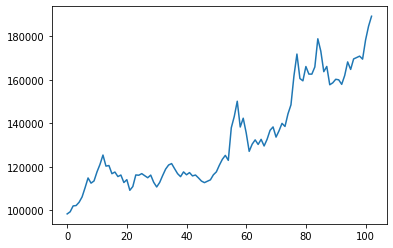

In [11]:
plt.figure()
plt.plot(market_values_)
plt.show()